In [1]:
# import glmnet_python
# from glmnet import glmnet

# Import relevant modules and setup for calling glmnet
%matplotlib inline

import time
import sys
import os
import re
from itertools import compress
from glob import glob
import pickle

import tensorflow as tf # data is in TFRecord format

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from scipy.io import loadmat

import numpy as np
from sklearn import linear_model
# from glmnet import glmnet; from glmnetPlot import glmnetPlot
# from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
# from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
# from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# glmnet has many deprecation warnings from using scipy.* instad of numpy.*
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def plot_distributions(y, y_hat):

    fig, axs = plt.subplots(2, 4, sharey=False, sharex=False, tight_layout=True)
    fig.set_size_inches(20,10)

    for ic in range(0,8):
        idx = np.unravel_index(ic, axs.shape)
        if ic < 4:
            axs[idx].set_title("Real %s"%names[ic])
            x = y[:,ic]        
        else:
            axs[idx].set_title("Predicted %s"%names[ic-4])
            x = y_hat[:,ic-4]
        axs[idx].hist(x, bins=20)

In [7]:
# Define constants
ncores = 28 # 56
names = ['DA', '5HT', 'pH', 'NE']
results_prefix = '/mnt/nfs/proj/in-vitro/Leonardo/glmnet/sklearn/fits/'
prefix = '/mnt/nfs/proj/in-vitro/Mark/four_analyte/slow/allin'
good_probes = ['CF025']
# good_probes = ['CF025', 'CF027', 'CF057', 'CF064', 'CF066', 'CF078', 'CF081', 'CF082']
# nrecords_per_session = 1 # One is special, loads one sweep per concentration per TFRecord
# nrecords_per_session = 2 # Any other number loads that amount of records in sequence from each TFRecord
nrecords_per_session = -1 # Loads all records
val_ratio = .1
# hold_probe = 0
hold_probe = -1 # split data randomly


In [3]:
# Load data

start_time = time.time()

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    def atoi(text):
        return int(text) if text.isdigit() else text
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def preprocess(serialized_example):
    features = tf.io.parse_example(
        serialized_example,
        features={
            'gram': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string)
        })
    data = tf.io.decode_raw(features['gram'], tf.float32)
    label = tf.io.decode_raw(features['label'], tf.float32)
    data.set_shape((None, 999))
    label.set_shape((None, 4))
    return data, label

def merge_datasets(vfiles, projy=lambda x: x, asnumpy=False):
    yv = []
    yl = []
    for filename in vfiles:
        ds = tf.data.TFRecordDataset(filename)
        ds = ds.batch(batch_size=2**13)
        ds = ds.map(map_func=preprocess)
        for v,l in ds:
            v = np.array(v).astype(np.float64)
            l = np.array(l).astype(np.float64)
            l = np.apply_along_axis(projy, axis=1, arr=l) 
            if nrecords_per_session == 1:
                _, ulidx = np.unique(l, return_index=True, axis=0)
                yv.append(v[ulidx,:])
                yl.append(l[ulidx,:])
            elif nrecords_per_session > 0:
                yv.append(v[:nrecords_per_session,:])
                yl.append(l[:nrecords_per_session,:])
            else:
                yv.append(v)
                yl.append(l)
#             print(yv[-1].shape)
#             print(yl[-1].shape)       
    x = np.vstack(yv)
    y = np.vstack(yl)

    if asnumpy:
        return x,y
    else:
        d = tf.data.Dataset.from_tensor_slices((x, y))
        return d

if hold_probe < 0:
    all_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])

    x, y = merge_datasets(all_files, asnumpy=True)
    
    idxs = np.random.permutation(x.shape[0])
    lim = int(x.shape[0]*(1-val_ratio))
    d1idx = idxs[idxs[:lim]]
    d2idx = idxs[idxs[lim:]]
    x_train, y_train, x_val, y_val = x[d1idx,:], y[d1idx,:], x[d2idx,:], y[d2idx,:]
else:
    hold_probe = good_probes.pop(hold_probe)
    train_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in good_probes
    ], [])
    x_train, y_train = merge_datasets(train_files, asnumpy=True)
    
    val_files = sum([
        sorted(tf.io.gfile.glob(os.path.join(prefix, probe, 'total_records', '*')),
               key=natural_keys) for probe in [hold_probe]
    ], [])
    x_val, y_val = merge_datasets(val_files, asnumpy=True)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)  

print("--- %s seconds ---" % (time.time() - start_time))


(55485, 999) (55485, 4)
(6165, 999) (6165, 4)
--- 2.4435653686523438 seconds ---


In [33]:
# alphas = np.linspace(0,.9,10)
l1_ratios = [1.,]
print(l1_ratios)
models = dict()

[1.0]


In [ ]:
# fit GLMNET in parallel (ncores) with cross validation to find lambda
ncross = 2
for l1_ratio in l1_ratios:
    print('Computing %d cross-validations for alpha %2.2f... '%(ncross, l1_ratio))
    start_time = time.time()


    # make results reproducible
    seed = 13
    np.random.seed(seed)
    tf.set_random_seed(seed)

    # Declare batch size
    batch_size = 50

    # Initialize placeholders
    x_data = tf.placeholder(shape=[None, 999], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 4], dtype=tf.float32)

    # Create variables for linear regression
    A = tf.Variable(tf.random_normal(shape=[999,4]))
    b = tf.Variable(tf.random_normal(shape=[1,4]))

    # Declare model operations
    model_output = tf.add(tf.matmul(x_data, A), b)

    # Declare the elastic net loss function
    elastic_param1 = tf.constant(1.)
    elastic_param2 = tf.constant(1.)
    l1_a_loss = tf.reduce_mean(tf.abs(A))
    l2_a_loss = tf.reduce_mean(tf.square(A))
    e1_term = tf.multiply(elastic_param1, l1_a_loss)
    e2_term = tf.multiply(elastic_param2, l2_a_loss)
    loss = tf.expand_dims(tf.add(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), e1_term), e2_term), 0)

    # Declare optimizer
    my_opt = tf.train.GradientDescentOptimizer(0.001)
    train_step = my_opt.minimize(loss)

    print(" took %s seconds" % (time.time() - start_time))

Computing 2 cross-validations for alpha 1.00... 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Path: 000 out of 010
Path: 001 out of 010
Path: 002 out of 010
Path: 003 out of 010
Path: 004 out of 010
Path: 005 out of 010
Path: 006 out of 010


/home/leonardo.barbosa/.conda/envs/inception/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:463: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20763269.465499878, tolerance: 15291450.894321876
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)


Path: 007 out of 010
Path: 008 out of 010


In [13]:
with open(os.path.join(results_prefix, 'cf_alpha_select.pickle'), 'wb') as f:
    pickle.dump(models, f)

1.0
alpha 1.00
DA: 308.92286
5HT: 150.38150
pH: 0.02517
NE: 370.36699


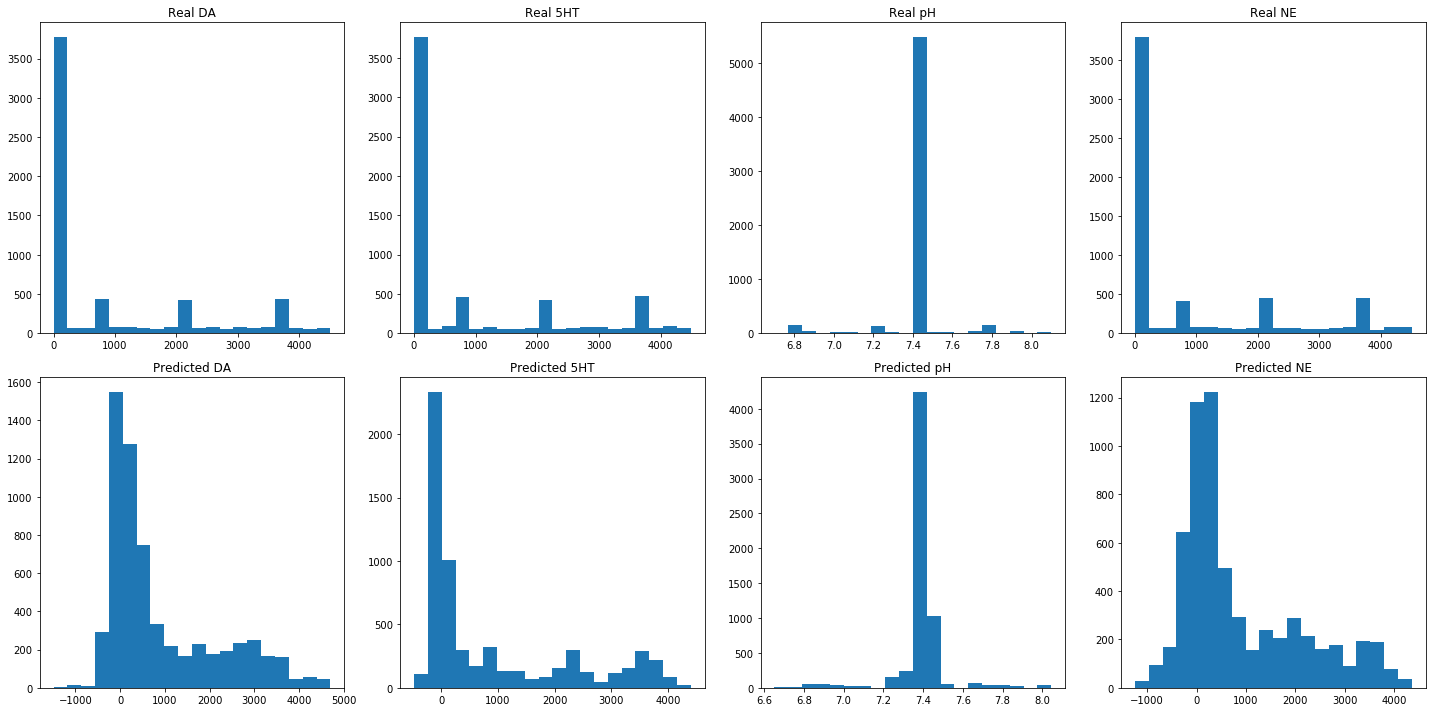

In [26]:
for l1_ratio in models:
    print(a)
    y_hat = models[l1_ratio].predict(x_val)
#     y_hat = fits[a](x_val, s='lambda_1se')
    print ('alpha %2.2f'%l1_ratio, flush=True)
    plot_distributions(y_val, y_hat)
    for (error, name) in zip(np.mean(np.sqrt((y_hat-y_val)**2),axis=0),names):
        print('%s: %4.5f'%(name,error), flush=True)
# 1.0
# alpha 1.00
# DA: 240.01289
# 5HT: 84.59803
# pH: 0.01701
# NE: 285.41925

In [30]:
models[l1_ratio].coef_.shape

(4, 999)

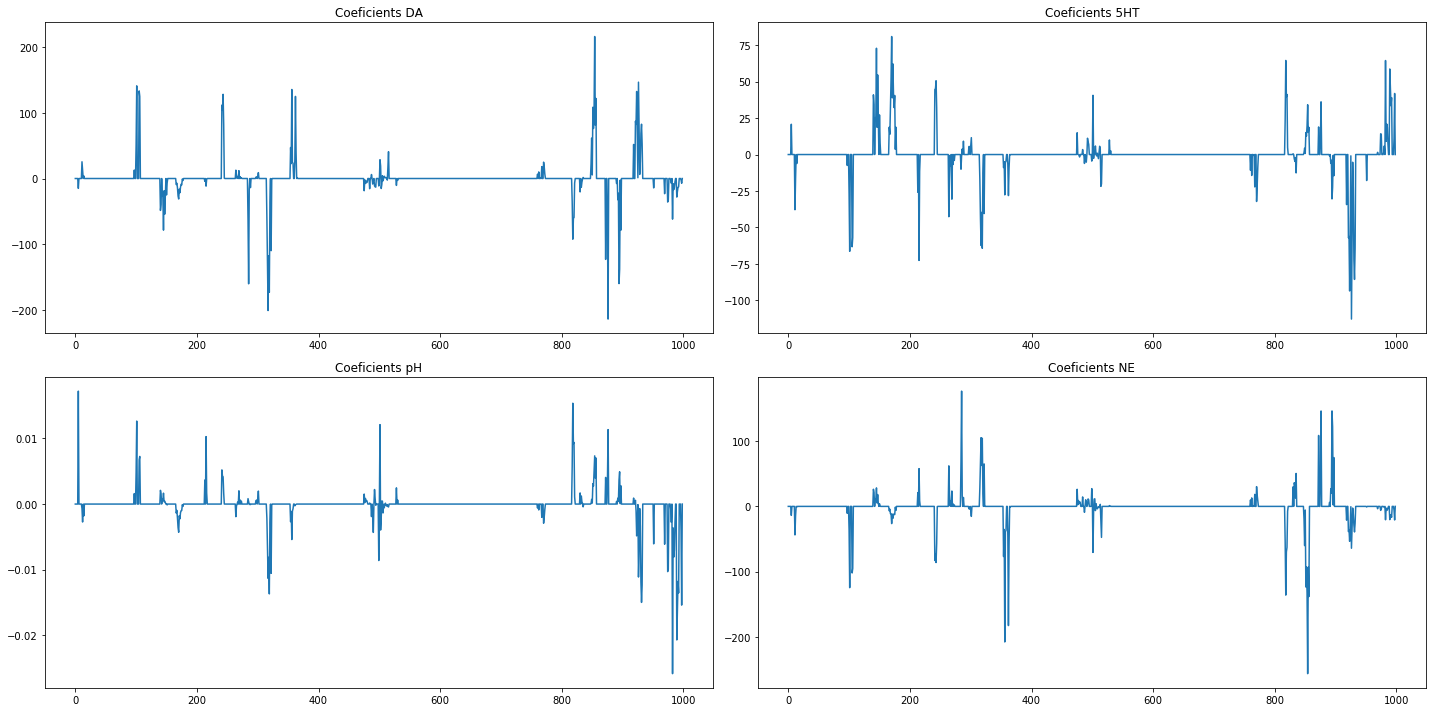

In [31]:
l1_ratio = 1.
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True)
fig.set_size_inches(20,10)
for ia in range(4):
    idx = np.unravel_index(ia, axs.shape)
    x = models[l1_ratio].coef_[ia,:]
    axs[idx].plot(x)
    axs[idx].set_title("Coeficients %s"%names[ia])

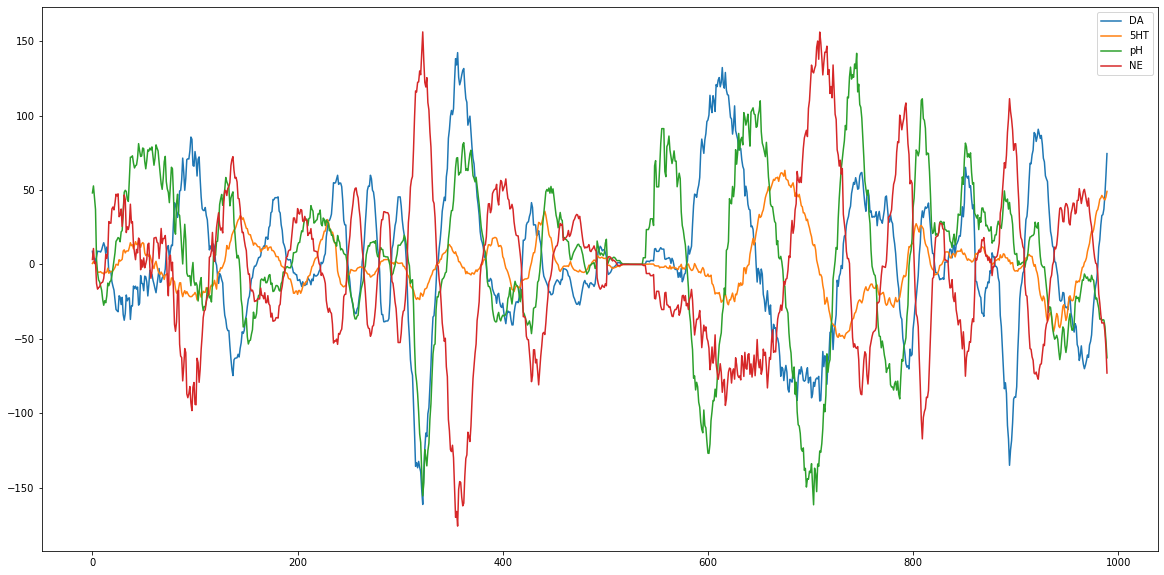

In [88]:
def smooth(y, w):
    #     box = np.ones(w)/w
    #     return np.convolve(y, box, mode='same')
        return np.convolve(y, np.ones(w), 'valid') / w

a = 1.
l = np.where([x == fits[a]['lambda_1se'][0] for x in fits[a]['lambdau']])[0][0]
fig, axs = plt.subplots()
fig.set_size_inches(20,10)
for ia in range(4):
    x = fits[1.]['glmnet_fit']['beta'][ia][:, l].copy()
    if ia == 2:
        x *= 15000
#     if ia == 3 or ia == 1:
#         axs.plot(-x, label=names[ia])
#     else:
    axs.plot(smooth(x, 10), label=names[ia])
axs.legend()